# NLP Tutorials

## Part 5: Embedding Words and Types

### Why Learn Embeddings? 

We've seen that you can use onehot representations—vectors that are the same length as the size of the vocabulary and that have 0s everywhere except a single position that has the value 1 to represent a specific word. The countbased representations are also called distributional representations because their significant content or meaning is represented by multiple dimensions in the vector. Low dimensional learned dense representations have several benefits over the onehot and countbased vectors we saw in previous chapters. Very high dimensions in the input can result in real problems in machine learning and optimization,the curse of dimensionality.

#### Efficiency of Encodings

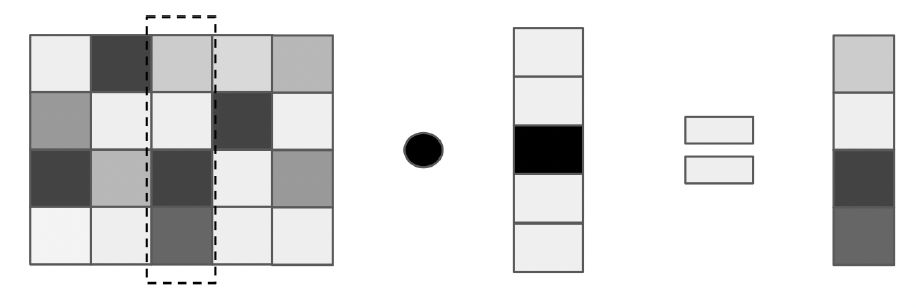

The weight matrix of a Linear Layer that accepts a one-hot vector as input must have the same number of rows. What ends up happening is that instead of doing matrix multiplication we can use an integer as an index to retrieve the selected row. Embeddings can represent words in a lower dimensional space than would be needed if a one hot vector or a count based representation was used.

### The Practical Use of Pretrained Word Embeddings

Pretrained word embeddings are embeddings that have already trained on a large corpus so they can be quite useful.

#### Loading Embeddings

Embeddings will come in the following format: each line starts with the word/type that is being embedded and is followed by a sequence of numbers (i.e., the vector representation). The length of this sequence is the dimension of the representation (aka the embedding dimension) and is is usually on the order of hundreds while the number of token types is usually the size of the vocabulary and on the order of a million. Popular encodings are Word2Vec, FastText, GLoVe, and BERT. We can download the file that holds an aforementioned encoding and read the encoding directly to use. A function to do this would look like:

In [11]:
def from_embeddings_file(cls, embedding_file):
    """
    Instantiate from pretrained vector file.
    Vector file should be of the format:
        word0 x0_0 x0_1 x0_2 x0_3 ... x0_N
        word1 x1_0 x1_1 x1_2 x1_3 ... x1_N
        ...   ...  ...  ...  ...  ...  ...
        wordm ...  ...  ...  ...  ... xm_N
        
    Args:
        embedding_file (str): location of the file
    Returns:
        instance of PretrainedEmbeddings
    """
    word_to_index = {}
    word_vectors = []
    
    with open(embedding_file) as fp:
        for line in fp.readlines():
            line = line.split(" ")
            word = line[0]
            vec = np.array([float(x) for x in line[1:]])
            word_to_index[word] = len(word_to_index)
            word_vectors.append(vec)
            
    return cls(word_to_index, word_vectors)

### Relationships Between Word Embeddings

The main feature from using word embeddings is that many relationships that show up as regularities can be made patterns out of. For example when talking about lions and tigers, there may be a lot of similarities between when compared to to whales or koalas. Using the format:

    Word1 : Word2 :: WordA : _______
    
what could possibly be after `WordA`? Thanks to word embeddings, a task like this is quite simple. We use the distance between `Word1` and `Word2` and then compare it to words around `Word3` in a nearest-neighbor query. Outputs would be looking like:

    blue : democrat :: red : republican
    
    talk : communicate :: read : interpret
    
    man : he :: woman : she
    
However, sometimes words that we know to be incorrect come such as:
    
    fast : fastest :: small : largest
    
Due to history and bias from the datasets collected the data can sometimes be 

    man : doctor :: woman : nurse

### Example: Learning the Continuous Bag of Words Embeddings

Let's use the book Frankenstein and use a tokenizer from `nltk` called `punkt` to tokenize the text. Then we can save it into a csv file so that we can easily access it after to be built vocab from.

#### Dataset Preprocessing

In [12]:
# import all the needed packages
import os
from argparse import Namespace
import collections
import nltk.data
import numpy as np
import pandas as pd
import re
import string
import json

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [13]:
# All Global Variables and Helper functions
args = Namespace(
    raw_dataset_txt="frankenstein.txt",
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="frankenstein_with_splits.csv",
    seed=1337
)

MASK_TOKEN = "<MASK>"

# helper function to remove and and turn all letters into lower case
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

# download the punkt package and save the file
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hritikarasu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# Split the raw text book into sentences
with open(args.raw_dataset_txt) as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)

# simplify all of the sentences 
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

# Create windows
flatten = lambda outer_list: [item for inner_list in outer_list for item in inner_list]
windows = flatten([list(nltk.ngrams([MASK_TOKEN] * args.window_size + sentence.split(' ') + \
    [MASK_TOKEN] * args.window_size, args.window_size * 2 + 1)) \
    for sentence in tqdm(cleaned_sentences)])

# Create cbow data
data = []
for window in tqdm(windows):
    target_token = window[args.window_size]
    context = []
    for i, token in enumerate(window):
        if token == MASK_TOKEN or i == args.window_size:
            continue
        else:
            context.append(token)
    data.append([' '.join(token for token in context), target_token])
    
            
# Convert to dataframe
cbow_data = pd.DataFrame(data, columns=["context", "target"])

# Create split data
n = len(cbow_data)
def get_split(row_num):
    if row_num <= n*args.train_proportion:
        return 'train'
    elif (row_num > n*args.train_proportion) and (row_num <= n*args.train_proportion + n*args.val_proportion):
        return 'val'
    else:
        return 'test'
cbow_data['split']= cbow_data.apply(lambda row: get_split(row.name), axis=1)

cbow_data.to_csv(args.output_munged_csv, index=False)

  0%|          | 0/3427 [00:00<?, ?it/s]

  0%|          | 0/90698 [00:00<?, ?it/s]

#### Classes and Helper Functions

Let us define a Vocabulary class ourself so that we have full control of vocab creation. This wil be similar to that of the previous lesson.

In [15]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
            
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

The vectorizer has a big task and what we are doing is new. We are not just creating one-hot vectors, we are creating a vector of integers describing the context's indices.

In [16]:
class CBOWVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, cbow_vocab):
        """
        Args:
            cbow_vocab (Vocabulary): maps words to integers
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cbow_df (pandas.DataFrame): the target dataset
        Returns:
            an instance of the CBOWVectorizer
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = \
            Vocabulary.from_serializable(contents['cbow_vocab'])
        return cls(cbow_vocab=cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}

In order to handle the dataset and feed it to the model there are many setps first. We need to split the data into training, validation, and test data. Another part of this class is being able to take advantage and create a vectorizer whether that be a completely new one or an already trained one.

In [17]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """
        Args:
            cbow_df (pandas.DataFrame): the dataset
            vectorizer (CBOWVectorizer): vectorizer instatiated from dataset
        """
        self.cbow_df = cbow_df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))
        
        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cbow_csv (str): location of the dataset
        Returns:
            an instance of CBOWDataset
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split=='train']
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, cbow_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            cbow_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of CBOWDataset
        """
        cbow_df = pd.read_csv(cbow_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(cbow_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of CBOWVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return CBOWVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
        
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

Here we create a simple CBoW model akin to the many that we have created already.

In [18]:
class CBOWClassifier(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        Args:
            vocabulary_size (int): number of vocabulary items, controls the
                number of embeddings and prediction vector size
            embedding_size (int): size of the embeddings
            padding_idx (int): default 0; Embedding will not use this index
        """
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size, 
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded_sum = F.dropout(self.embedding(x_in).sum(dim=1), 0.3)
        y_out = self.fc1(x_embedded_sum)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out

Below are helper methods for training our model. We have to define a lot of these methods because all of the tools that we typically use are not predefined.

In [19]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

#### Model Instantiation

In [29]:
args = Namespace(
    # Data and Path information
    cbow_csv="frankenstein_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="cbow",
    # Model hyper parameters
    embedding_size=50,
    # Training hyper parameters
    seed=1337,
    num_epochs=3,
    learning_rate=0.0001,
    batch_size=32,
    early_stopping_criteria=5,
    # Runtime options
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

if args.reload_from_files:
    print("Loading dataset and loading vectorizer")
    dataset = CBOWDataset.load_dataset_and_load_vectorizer(args.cbow_csv,
                                                           args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size=len(vectorizer.cbow_vocab), 
                            embedding_size=args.embedding_size)

Expanded filepaths: 
	cbow/vectorizer.json
	cbow/model.pth
Using CUDA: False
Loading dataset and creating vectorizer


#### Training

In [30]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()
        
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/3 [00:00<?, ?it/s]

split=train:   0%|          | 0/1984 [00:00<?, ?it/s]

split=val:   0%|          | 0/425 [00:00<?, ?it/s]

	Train Loss: 9.241 | Train Acc: 126.80%
	Validation Loss: 8.426 | Validation Acc: 263.24%
	Train Loss: 7.885 | Train Acc: 442.60%
	Validation Loss: 7.841 | Validation Acc: 515.44%
	Train Loss: 7.347 | Train Acc: 691.15%
	Validation Loss: 7.528 | Validation Acc: 678.68%


#### Testing

In [31]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


	Test Loss: 8.280 | Test Acc: 671.32%


### Model Prediction

Using what we have gained from the model, we can use it to find patterns from other texts. Doing so would be called Transfer Learning. What we will be doing is using our embedding layer that we have gained and use it on words or sentences. Let's see how this would work on text that we gave our NBoW Frankenstein model.

In [45]:
# specify the embeddings and the word_to_idx as a global variable
embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx

# function doing a version of nearest neighbors
def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """

    # Calculate distances to all other words
    
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    
    for word, index in word_to_idx.items():
        # if the word is the same or it was a hidden word continue
        if word == MASK_TOKEN or word == target_word:
            continue
        # else add it to the distances list
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    # return the words and their distances from closest to furthest
    return sorted(distances, key=lambda x: x[1])[1:n+2]

In [47]:
# given words
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

for word in target_words: 
    print(f"\n\t{word}")
    # if the word is not in the vocabulary, then skip it
    if word not in word_to_idx:
        print("Not in vocabulary")
        continue
    # else find the closest 5 words based on the given embedding
    for item in get_closest(word, word_to_idx, embeddings, n=5):
        print ("   [%.2f] - %s"%(item[1], item[0]))


	frankenstein
   [6.89] - dead
   [6.95] - slight
   [6.96] - oppressive
   [6.99] - discrimination
   [7.01] - spurned
   [7.09] - illustrate

	monster
   [7.85] - saw
   [7.86] - kid
   [7.94] - truly
   [7.95] - cares
   [7.95] - ultimately
   [7.99] - confused

	science
   [7.06] - impression
   [7.10] - mutual
   [7.14] - darkened
   [7.16] - mist
   [7.29] - swelling
   [7.35] - tempted

	sickness
   [6.35] - while
   [6.56] - literally
   [6.60] - foundations
   [6.60] - probabilities
   [6.69] - awoke
   [6.69] - consoles

	lonely
   [6.94] - moonlight
   [6.95] - unveiled
   [7.22] - ought
   [7.24] - heartily
   [7.27] - bed
   [7.30] - undiscovered

	happy
   [6.46] - bottom
   [6.54] - injury
   [6.56] - chimney
   [6.64] - evening
   [6.65] - lingered
   [6.66] - chivalry


Try it with your own word as well!

In [48]:
# get user input of a word
word = input('Enter a word: ')

# else find the closest 5 words based on the given embedding
for item in get_closest(word, word_to_idx, embeddings, n=5):
    print ("   [%.2f] - %s"%(item[1], item[0]))

Enter a word: happy
   [6.46] - bottom
   [6.54] - injury
   [6.56] - chimney
   [6.64] - evening
   [6.65] - lingered
   [6.66] - chivalry
